# Generate samples for a single scene

In [1]:
import sys
import os
import pylab as plt
import numpy as np
from matplotlib.colors import ListedColormap
from osgeo import gdal
from osgeo import ogr
from importlib import reload
from shapely.geometry import Polygon
from shapely.wkb import loads
import skimage

sys.path.insert(0, '../src')
import datasetGen.rasterizer as rstzr
import datasetGen.sampleGenerator as sg
import utils.filesystem as fs

reload(rstzr)
reload(sg)
reload(fs)

%matplotlib inline

In [2]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
raster_file = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-B1-7.tif")
class_column = "agregClass"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated')
fs.mkdir(output_path)
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "samples_dataset.npz")

number_of_samples = 5000
window_size = 21

## Rasterize the input shape file

In [3]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (7741, 7591)


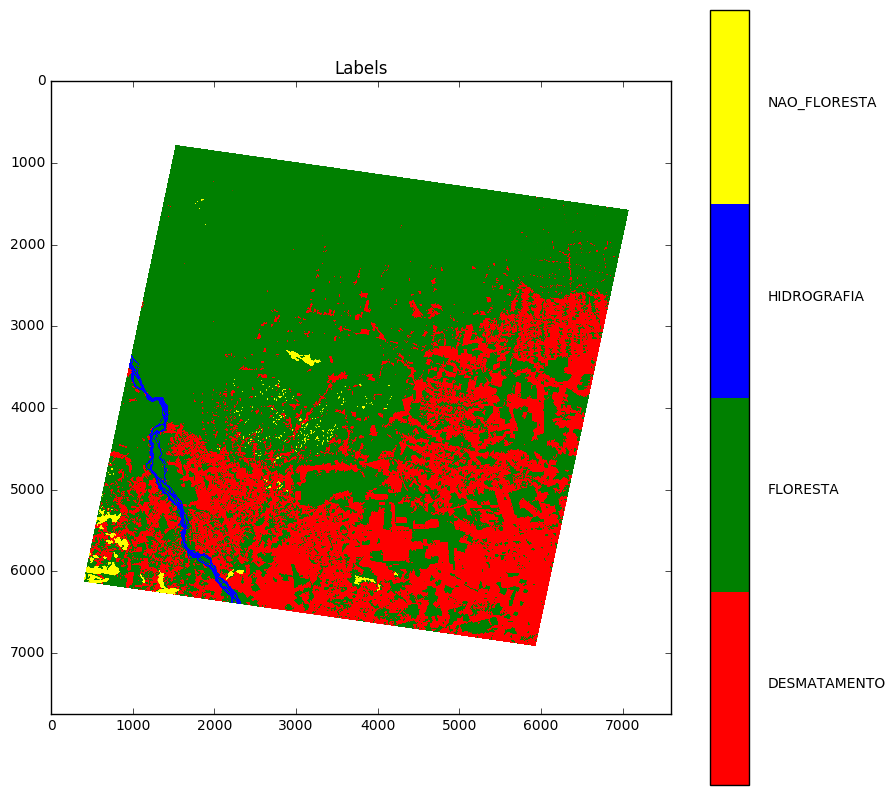

In [4]:
plt.figure(figsize=(10, 10))
plt.title('Labels')
print("Raster Shape:", rasterized_layer.shape)
labels = np.ma.masked_where(rasterized_layer == 255, rasterized_layer)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
plt.imshow(rasterized_layer, cmap=colorMap)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(class_names):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15

In [5]:
raster_ds = gdal.Open(raster_file)
raster_img = raster_ds.ReadAsArray()
raster_img = np.rollaxis(raster_img, 0, start=3)
smpGen = sg.SampleGenerator(raster_img, rasterized_layer, class_names, raster_file)
smpGen.compute_sample_indexes(number_of_samples)
smpGen.extract_windows(window_size)
smpGen.save_samples_SHP(output_shp)
smpGen.save_samples_NPZ(output_npz)

In [6]:
# - Create execute method. 
# - Implement method to save to geotiff. In this method, allow the user to pass a list of indexes to save (none saves everything)

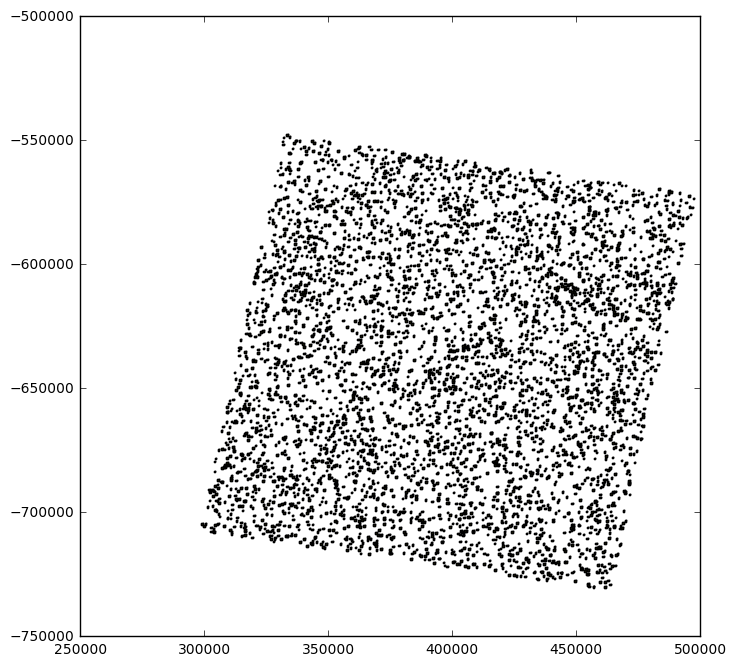

In [7]:
#TODO: How to plot the raster together? Decrease the blank space from the origin to the data
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
out_ds = ogr.Open(output_shp)

layer = out_ds.GetLayerByName(os.path.splitext(os.path.basename(output_shp))[0])
parcel = layer.GetNextFeature()

while parcel is not None:
    polygon = loads(parcel.GetGeometryRef().ExportToWkb())
    xCoord , yCoord = polygon.exterior.xy
    ax.fill(xCoord,yCoord,"y")
    ax.plot(xCoord,yCoord, "k-")
    parcel = layer.GetNextFeature()

out_ds.Destroy()

labels[ 1715 ] [0 1]
labels[ 4597 ] [0 1 3]
labels[ 4721 ] [1]
labels[ 1220 ] [0]
labels[ 3554 ] [1 2]
labels[ 1315 ] [1]
labels[ 503 ] [1]
labels[ 1810 ] [0 1]
labels[ 1903 ] [1]
labels[ 1370 ] [1]
labels[ 1777 ] [0]
labels[ 2853 ] [0 1]


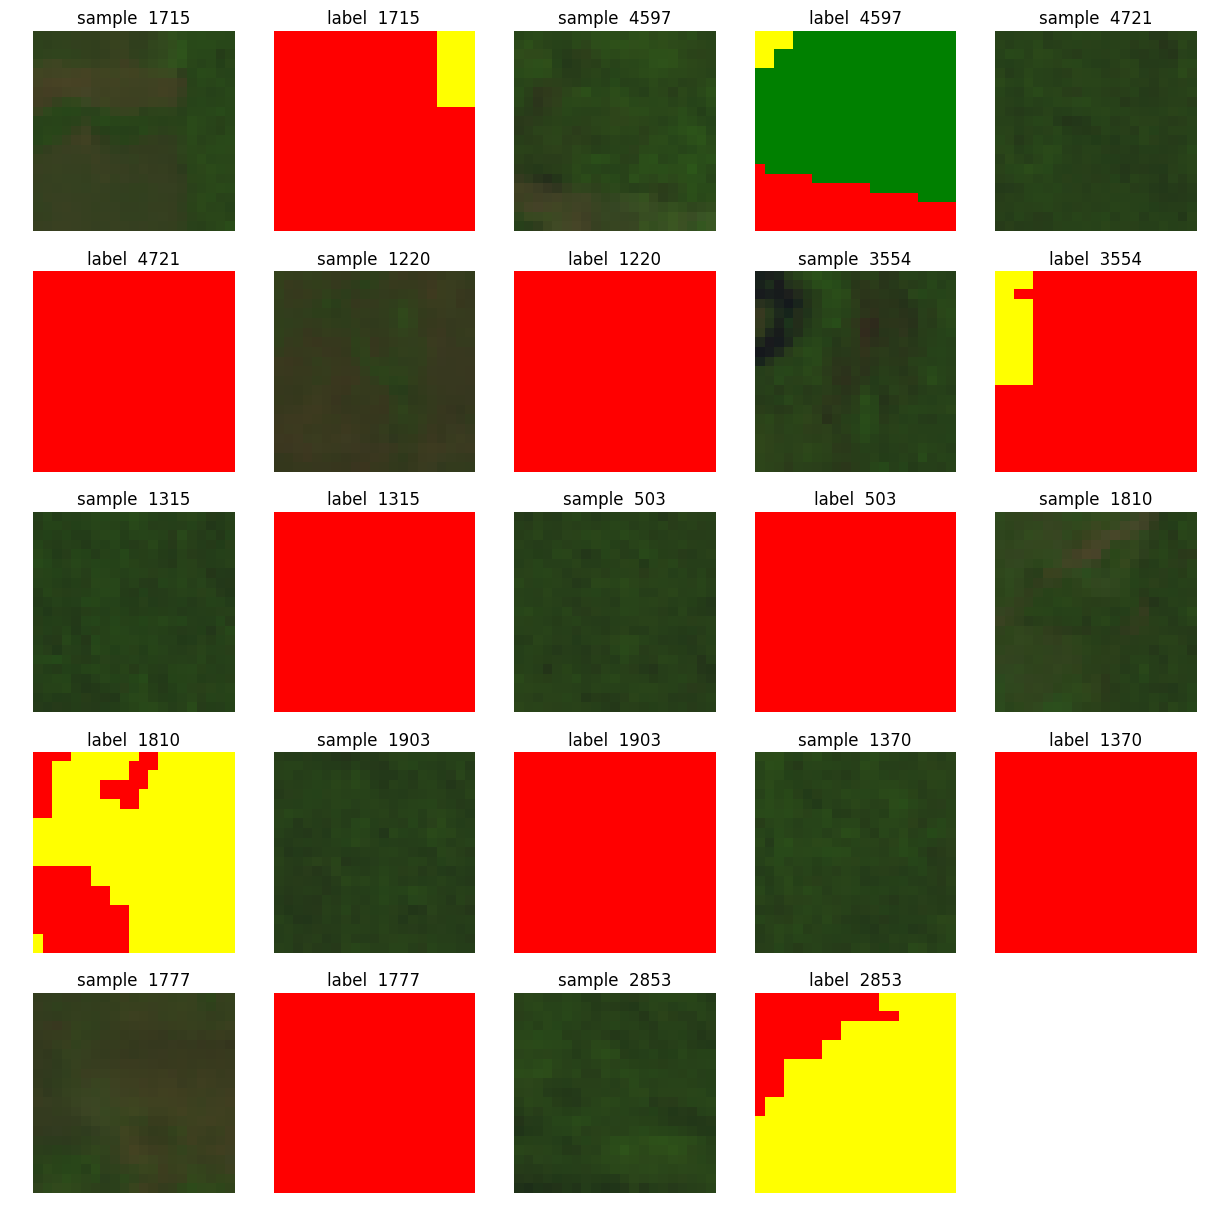

In [38]:
samples = smpGen.getSamples()
plt.figure(figsize=(15,15))

#TODO: Some samples has no data value only in labels. Is it necessary to remove no data or clip the base raster?
# Why is the forest being printed in yellow?? Search for how to set colors by values. It seems to be by range
count = 1
for x in range(1, 13):
    pos = np.random.randint(len(samples["img_samples"]))
    smpImg = samples["img_samples"][pos]
    smpImg = skimage.img_as_float(smpImg).astype(np.float32)
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("sample ", pos))
    plt.axis('off')
    plt.imshow(smpImg[:,:,[5,4,3]], interpolation='nearest')
    count=count+1
    
    lblImg = samples["labels"][pos]
    colorMap = ListedColormap(["red", "green", "blue", "yellow"])
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("label ", pos))
    plt.axis('off')
    plt.imshow(lblImg, interpolation='nearest', cmap=colorMap)
    count=count+1
    print("labels[", pos, "]:", np.unique(lblImg))

In [36]:
print(class_names)
colors = []
for cl in class_names:
    if cl == "DESMATAMENTO":
        colors.append("red")
    elif cl == "FLORESTA":
        colors.append("green")
    elif cl == "HIDROGRAFIA":
        colors.append("blue")
    elif cl == "NAO_FLORESTA":
        colors.append("yellow")

print(colors)

['DESMATAMENTO', 'FLORESTA', 'HIDROGRAFIA', 'NAO_FLORESTA']
['red', 'green', 'blue', 'yellow']
